In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator import get_tf_DataSet as getGenerators
from tqdm import tqdm
import pickle as pkl
from scipy.stats import norm
import sys
import mertens_models as mertens
from matplotlib.gridspec import GridSpec
import scienceplots
plt.style.use(["science", "grid"])

In [60]:
def get_predictions_per_subset( probability, n_samples_per_subset, cross_sections = [0.,0.1,1.0], return_weights=False):
    
    cross_sections = np.array(cross_sections)
    nDM_Models =   probability.shape[2]
    nMonte_carlo = probability.shape[0]
    nClusters = probability.shape[1]

    nSubSets = nClusters//n_samples_per_subset
    subset_means, subset_stds, prediction = [], [], []

    for iSubSet in range(nSubSets):
        final_probs = np.ones( (nMonte_carlo, nDM_Models))
        this_subset = np.arange(iSubSet*n_samples_per_subset, min([(iSubSet+1)*n_samples_per_subset, nClusters]))
        for iMonteCarlo in range(nMonte_carlo):
        
            final_probs_per_cluster_per_MC = probability[iMonteCarlo, this_subset,: ]
            #normalise this probability
            final_probs_per_cluster_per_MC = final_probs_per_cluster_per_MC / np.sum(final_probs_per_cluster_per_MC,axis=1)[:,np.newaxis]

            for iCluster in range(final_probs_per_cluster_per_MC.shape[0]):
                final_probs[iMonteCarlo] *= final_probs_per_cluster_per_MC[iCluster]
                final_probs[iMonteCarlo] /= np.sum(final_probs[iMonteCarlo])
                
        final_probs_all = np.sum(final_probs, axis=0) 
        
        
        #newprob = np.sum(probability[:, this_subset,: ],axis=0)
        #newprob /= np.sum(newprob,axis=1)[:,np.newaxis]
        
        #cluster_means = np.sum(newprob*[0.,0.1,1.0],axis=1)/np.sum(newprob,axis=1)
        #cluster_stds = np.sqrt( np.sum(newprob*( np.array([cross_sections - i for i in cluster_means]) )**2, axis=1))
        
        
        #subset_means.append(np.mean(cluster_means))
        #subset_stds.append(np.sqrt(np.sum(cluster_stds**2))/len(np.sqrt(cluster_stds)))
        
    #return np.array(subset_means), np.array(subset_stds)
        
    
        #prediction.append(np.exp(np.average([np.log(0.01),np.log(0.01),np.log(0.01),np.log(0.1),0.], weights=final_probs_all
        if return_weights:
            prediction.append( final_probs )
        else:
            prediction.append(np.average(cross_sections, weights=final_probs_all))


    return np.array(prediction)

In [4]:
#Numbers that define how long this script takes -
epochs = 80 # Epochs for each model to train
monte_carlo = 10 # Number of shuffles of the training / test set and retrains

In [61]:
nDM_Models = 5 #Number of classifications in the model
if os.path.isfile("pickles/final_model.pkl"):
    all_probs, prob_sidm0_3, monte_carlo_histories = pkl.load(open("pickles/final_model.pkl","rb"))
 

In [98]:
def get_best_model( image_generator, test_set, model_name='Inception', checkpoint_filepath="models" ):
    
    if os.path.isdir(checkpoint_filepath):
        print("Found Model")
        return tf.keras.models.load_model(checkpoint_filepath)
        
        
    num_classes = len(np.unique(test_set[1]))
    
    if model_name.lower() == 'simple':
        model = simpleCNN.getModel_ds(num_classes)
    elif model_name.lower() == 'dibare':
        model = mertens.DIBARE(input_shape=test_set[0][0].shape, classes=num_classes, bn_momentum=.0, 
                                FC1=0,FC2=0,feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)
    elif model_name.lower() == 'inception':
        model = mertens.InceptionV4(input_shape=test_set[0][0].shape, bn_momentum=.0,classes=num_classes,
                                               feature_dropout=.33,num_layersA=1,num_layersB=1,num_layersC=1,leak=.03)

    else:
        raise ValueError("Model name not recognised")
    
    optimizer = tf.keras.optimizers.Adam( learning_rate=1e-3 ) 
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    
    
    history = model.fit(
      x=image_generator,
      validation_data=test_set,
      epochs=epochs, verbose=1, callbacks=[model_checkpoint_callback])
    
    return model
    
    

#### Train many models with differeing random states to get variance in model.

In [54]:
all_probs, prob_sidm0_3, monte_carlo_histories = pkl.load(open("pickles/final_inception_model.pkl","rb"))

In [ ]:
model_name = 'inception'
monte_carlo_tests = [] #A record of the test sets used
monte_carlo_histories = [] #A record of the histories of the modelling
all_probs = [] #A record of the probabilities predicted for the test set
prob_sidm0_3 = [] # A record of the probabilities predicted for SIDM 0.3 test set
simulationNames = ['CDM','SIDM0.1','SIDM1']
nDM_Models = len(simulationNames)

for i in tqdm(range(monte_carlo)):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
   
    checkpoint_filepath = 'models/%s/%i' % (model_name, i)
  
    model = get_best_model( train, test, model_name=model_name, checkpoint_filepath=checkpoint_filepath)
    
    monte_carlo_tests.append( test )
    monte_carlo_histories.append( model.history.history )
    
    iDM_model_probs = [] 
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]

        
        iDM_model_probs.append(model.predict( this_dm_model_test_feat, verbose=0 ))
    all_probs.append(iDM_model_probs)
    
    train, test = getGenerators(augment_data=True, simulationNames=['SIDM0.3'], train_split=0.01, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
    
    prob_sidm0_3.append(model.predict( test[0], verbose=0 ))
    
all_probs = np.array(all_probs)
prob_sidm0_3 = np.array(prob_sidm0_3)

pkl.dump([all_probs, prob_sidm0_3, monte_carlo_histories], open("pickles/final_inception_model.pkl","wb"))

#### Now see the distribution of probabilities for cluster for each model - not really fair since i trian on these and they are far apart.

In [ ]:
c = ['r','b','g','c','purple']

nDM_Models = all_probs.shape[1]
  
n_samples_per_subset = 10  
ax = plt.gca()

stds = []
for iDM_model in range(nDM_Models):
    
    prediction = get_predictions_per_subset( all_probs[:,iDM_model,:,:], n_samples_per_subset,  cross_sections=[0.0,0.1,1.0])

    #ax.hist(prediction, color=c[iTelescope], alpha=0.5, density=True, bins=np.linspace(0.,0.5,10))
    
    mean = np.median(prediction)
    std = np.std(prediction)
    print(mean,std)
    stds.append(std)
    x = np.logspace(-2,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[iDM_model])
    
    if iTelescope == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[iDM_model], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[iDM_model], label='Sample Size: %i' % n_samples_per_subset )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[iDM_model])

ax.set_xlim(1e-3,1.5)
#ax.set_xticks(np.linspace(0,0.5,6))
ax.set_xscale('log')
ax.plot([0.3,0.3],[0,12],'k-',label='Blind Truth')
ax.legend(loc=2)
plt.savefig("../plots/dm_models_blind_test.pdf")

#### Now look at how well it does at guessing SIDM0.3!

0.10311566067079007
0.0312632366241746
0.012242711551426515


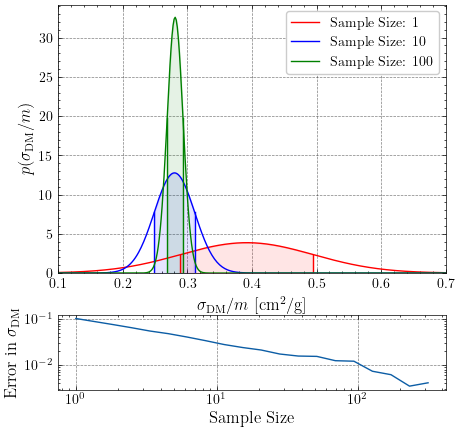

In [62]:
plt.figure(figsize=(5,5))
gs = GridSpec(20,1)

ax = plt.subplot(gs[:14,0])
c = ['r','b','g','c']
stds = []
for iTelescope, n_samples_per_subset in enumerate([ 1, 10, 100]):
    
    prediction = get_predictions_per_subset( prob_sidm0_3, n_samples_per_subset,  cross_sections=[0.0,0.1,1.0])

    #ax.hist(prediction, color=c[iTelescope], alpha=0.5, density=True, bins=np.linspace(0.,0.5,10))
    
    mean = np.median(prediction)
    std = np.std(prediction)/np.sqrt(n_samples_per_subset)
    print(std)
    stds.append(std)
    x = np.logspace(-2,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[iTelescope])
    
    if iTelescope == 0:
        ylims = ax.get_ylim()
    #ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[iTelescope])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[iTelescope], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[iTelescope], label='Sample Size: %i' % n_samples_per_subset )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[iTelescope])
subsets = np.logspace(0,2.5,20)
stds = [ np.std(  get_predictions_per_subset( prob_sidm0_3, int(i)))/np.sqrt(i) for i in subsets ]
ax1 = plt.subplot(gs[16:,0])
ax1.set_yscale('log')

ax1.plot(subsets, stds)
ax1.set_xlabel('Sample Size',fontsize=12)
ax1.set_ylabel('Error in $\sigma_{\\rm DM}$',fontsize=12)
ax1.set_xscale('log')


ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlim(0.1,0.7)

#ax.set_xticks(np.linspace(0,0.5,6))
#ax.set_xscale('log')
#ax.plot([0.3,0.3],[0,12],'k-',label='Blind Truth')
ax.legend(loc=1)
ax.set_ylim(0,ax.get_ylim()[1])
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]',fontsize=12)
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$',fontsize=12)
plt.savefig("../plots/sidm_0p3_blind_test.pdf")

### Now I am doing the same but asking what happens if i dont train on CDM_hi and it is CDM_hi

In [12]:
all_probs, prob_test, monte_carlo_histories = pkl.load( open("pickles/final_inception_model_wrong_baryons.pkl","rb"))

In [ ]:
model_name = 'inception'
monte_carlo_tests = [] #A record of the test sets used
monte_carlo_histories = [] #A record of the histories of the modelling
all_probs = [] #A record of the probabilities predicted for the test set
prob_test = [] # A record of the probabilities predicted for SIDM 0.3 test set
simulationNames = ['CDM_low','CDM','SIDM0.1','SIDM1']
test_name = 'CDM_hi'
nDM_Models = len(simulationNames)

for i in tqdm(range(monte_carlo)):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
   
    checkpoint_filepath = 'models/%s_wrong_baryons/%i' % (model_name, i)
  
    model = get_best_model( train, test, model_name=model_name, checkpoint_filepath=checkpoint_filepath)
    
    monte_carlo_tests.append( test )
    monte_carlo_histories.append( model.history.history )
    
    iDM_model_probs = [] 
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]

        
        iDM_model_probs.append(model.predict( this_dm_model_test_feat, verbose=0 ))
        
    all_probs.append(iDM_model_probs)
    
    train, test = getGenerators(augment_data=True, simulationNames=[test_name], train_split=0.01, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
    
    prob_test.append(model.predict( test[0], verbose=0 ))
    
all_probs = np.array(all_probs)
prob_test = np.array(prob_test)

pkl.dump([all_probs, prob_test, monte_carlo_histories], open("pickles/final_inception_model_wrong_baryons.pkl","wb"))

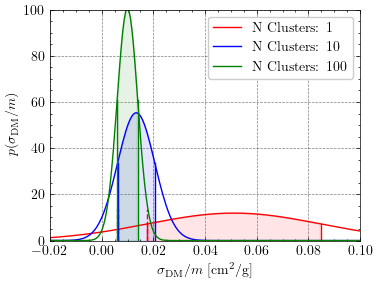

In [18]:
c = ['r','b','g','c','purple']
plt.figure(figsize=(4,3))

for i, iSubSample in enumerate(np.logspace(0,2,3)):
    prediction = get_predictions_per_subset( prob_test, int(iSubSample), cross_sections=[0,0.,0.1,1.0], return_weights=False)
    ax = plt.gca()

    
    mean = np.median(prediction)
    std = np.std(prediction)#/np.sqrt(len(prediction))
    x = np.linspace(-0.1,0.5,1000)
    pdf = norm.pdf(x, mean, std)
    ax.plot(x, pdf, color=c[i])
    if i == 0:
        ylims = ax.get_ylim()
    ax.plot([mean-std,mean-std],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean,mean],[0,ylims[1]*1.1],'--', color=c[i])
    #ax.plot([mean+std,mean+std],[0,ylims[1]*1.1],'--', color=c[i])
    ax.fill_between( x[ (x > mean-std) & (x < mean+std) ], 
                    np.zeros(len(x[ (x > mean-std) & (x < mean+std) ])),
                    pdf[ (x > mean-std) & (x < mean+std) ], color=c[i], alpha=0.1)
    ax.plot( [mean-std,mean-std],[0,norm.pdf(mean-std, mean, std)], '-',color=c[i], label="N Clusters: %i" % iSubSample )
    ax.plot( [mean+std,mean+std],[0,norm.pdf(mean+std, mean, std)], '-',color=c[i])

#ax.set_ylim(0,12)
ax.set_xlim(-0.02,0.1)
#ax.set_xscale('log')
ylim = ax.get_ylim()
#ax.plot([0.1,0.1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
#ax.plot([1,1],[0,ylim[1]*1.1],'k-',label='Blind Truth')
ax.set_ylim(0,100)
ax.legend(loc=1)
ax.set_xlabel(r'$\sigma_{\rm DM}/m$ [cm$^2$/g]')
ax.set_ylabel(r'$p(\sigma_{\rm DM}/m)$')

plt.savefig("../plots/dm_models_dm_wrong.pdf")


### Variance in the accuracy

In [34]:
simulationNames = ['CDM','SIDM0.1','SIDM1']


In [36]:
all_probs.shape

(10, 4, 240, 4)

In [48]:
preds = [] 
m = tf.keras.metrics.Accuracy()
m.result().numpy()
nDM_Models = all_probs.shape[1]
for iM in range(all_probs.shape[0]):
    train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=iM)
    iPreds = np.array([])
    
    for iDM_model in range(nDM_Models):
        this_dm_model_test_feat = test[0][ test[1] == iDM_model ]
        this_dm_model_test_labels = test[1][ test[1] == iDM_model ]


        predictions = np.argmax( all_probs[iM, iDM_model,:,:], axis=1)
        m.update_state( predictions, this_dm_model_test_labels )
    
        iPreds = np.append(iPreds, m.result().numpy())
    
    preds.append( iPreds)

                

In [45]:
m

0.7057292